In [14]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [15]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime, timedelta

In [17]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [18]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [19]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [20]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement

In [21]:
# Create a session
Station = Base.classes.station


# Exploratory Precipitation Analysis

In [34]:
# Find the most recent date in the data set.
session = Session(engine)
# Query to get the most recent date
most_recent_date = session.query(func.max(Measurement.date)).scalar()

most_recent_date,

('2017-08-23',)

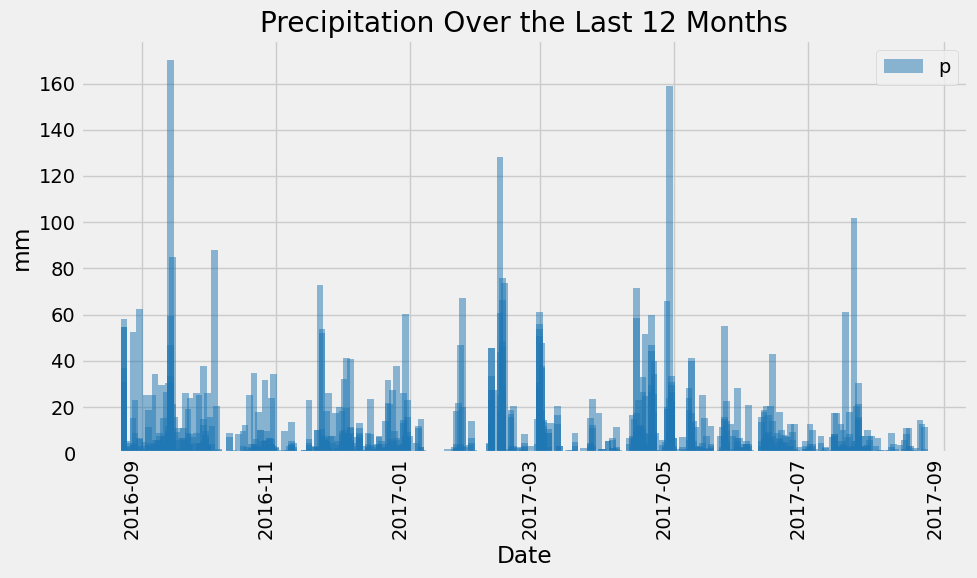

In [94]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
# Find the most recent date
most_recent_date_str = session.query(func.max(Measurement.date)).scalar()

# Convert to datetime object
most_recent_date = datetime.strptime(most_recent_date_str, '%Y-%m-%d')

# # Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - timedelta(days=365)

# # Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(
    Measurement.date, Measurement.prcp
).filter(
    Measurement.date >= one_year_ago
).order_by(
    Measurement.date
).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], width=3, color='tab:blue', alpha=0.5)
plt.title("Precipitation Over the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("mm")
plt.xticks(rotation=90, ha='right')
plt.legend('precipitation')
plt.tight_layout()
plt.show()

In [110]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
print("     precipitation")
print("__________________")
summary_statistics

     precipitation
__________________


count    5.000000
mean     0.300000
std      0.158114
min      0.100000
25%      0.200000
50%      0.300000
75%      0.400000
max      0.500000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [43]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).count()

[(total_stations,)]

[(9,)]

In [57]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    Measurement.station,  
    func.count(Measurement.station)  # Count of rows for each station
).group_by(
    Measurement.station  # Grouping by station
).order_by(
    func.count(Measurement.station).desc()  # Sorting by the count in descending order
).all()

# Display the most active stations and their counts
for station, count in most_active_stations:
    print((station, count),)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [44]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = session.query(Measurement.station)\
    .group_by(Measurement.station)\
    .order_by(func.count().desc())\
    .first()[0]

# Query to calculate lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs))\
                            .filter(Measurement.station == most_active_station_id)\
                            .all()

# Extracting results and formatting as requested
temperature_stats_formatted = [(round(temperature_stats[0][0], 1),
                                round(temperature_stats[0][1], 1),
                                round(temperature_stats[0][2], 12))]

print(temperature_stats_formatted)

[(12.2, 29.4, 22.035822510823)]


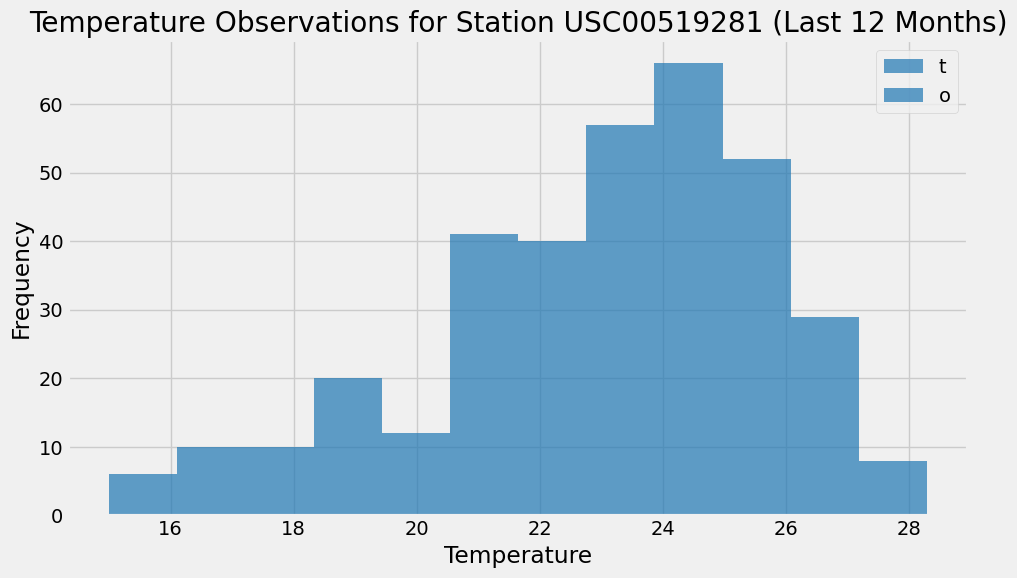

In [79]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Identify the most active station
most_active_station = session.query(
    Measurement.station, func.count(Measurement.station)
).group_by(
    Measurement.station
).order_by(
    func.count(Measurement.station).desc()
).first()  # Get the first (most active) station

most_active_station_id = most_active_station[0]

# Find the most recent date in the dataset
most_recent_date_str = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date_str, '%Y-%m-%d')

# Calculate the date one year ago
one_year_ago = most_recent_date - timedelta(days=365)

# Query temperature data for the most active station in the last 12 months
temperature_data = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.date >= one_year_ago)\
    .filter(Measurement.date <= most_recent_date)\
    .filter(Measurement.station == most_active_station_id)\
    .order_by(Measurement.date).all()

# Plot the data as a histogram
# Convert the query results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Create a histogram of the temperature data
plt.figure(figsize=(10, 6))
temperature_df['Temperature'].plot(kind='hist', bins=12, color='tab:blue', alpha=0.7)
plt.title(f'Temperature Observations for Station {most_active_station_id} (Last 12 Months)')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend('tobs')
plt.tight_layout()
plt.show()

# Close Session

In [112]:
# Close Session
session.close()
